In [17]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from datetime import datetime
import logging
import itertools

plt.style.use('ggplot')

In [18]:
df = pd.read_csv('sp500_index.csv')
df['Date'] = pd.to_datetime(df['Date'])

In [19]:
df.tail()

,Date,S&P500
2512,2023-05-31,4179.83
2513,2023-06-01,4221.02
2514,2023-06-02,4282.37
2515,2023-06-05,4273.79
2516,2023-06-06,4283.85


In [20]:
profile = ProfileReport(df, title="Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

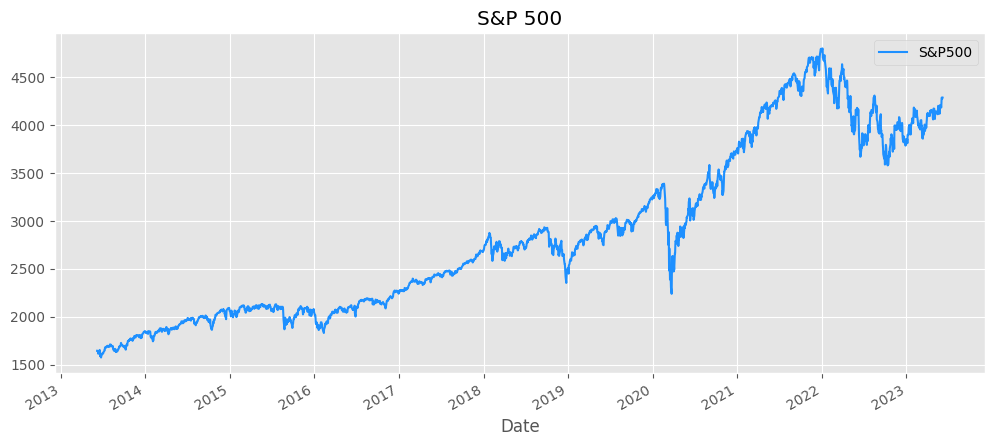

In [21]:
df.plot(style='-',
        figsize=(12,5),
        x='Date',
        y='S&P500',
        title='S&P 500',
        color='dodgerblue')
plt.show()

In [22]:
df_prophet = df.rename(columns={'Date':'ds',
                                'S&P500':'y'})

In [23]:
df_prophet.head()

,ds,y
0,2013-06-07,1643.38
1,2013-06-10,1642.81
2,2013-06-11,1626.13
3,2013-06-12,1612.52
4,2013-06-13,1636.36


In [24]:
%%time
model = Prophet(interval_width=0.95, weekly_seasonality=False)
model.add_country_holidays(country_name='US')
model.fit(df_prophet)

11:40:33 - cmdstanpy - INFO - Chain [1] start processing
11:40:34 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 163 ms, sys: 1.15 ms, total: 165 ms
Wall time: 1.27 s


In [25]:
future = model.make_future_dataframe(periods=30, freq='B')
forecast = model.predict(future)

In [26]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2542,2023-07-12,3892.918826,3644.640470,4124.230350,3872.298110,3905.643451,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-13.453109,-13.453109,-13.453109,0.0,0.0,0.0,3879.465717
2543,2023-07-13,3892.203833,3640.099811,4112.232023,3869.946592,3905.454496,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-10.152198,-10.152198,-10.152198,0.0,0.0,0.0,3882.051635
2544,2023-07-14,3891.488840,3637.415914,4143.806675,3868.145891,3905.529778,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-6.972717,-6.972717,-6.972717,0.0,0.0,0.0,3884.516123
2545,2023-07-17,3889.343861,3640.994678,4134.215534,3864.795284,3904.175074,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.658115,1.658115,1.658115,0.0,0.0,0.0,3891.001976
2546,2023-07-18,3888.628868,3651.076500,4167.156974,3862.112475,3904.543596,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.195295,4.195295,4.195295,0.0,0.0,0.0,3892.824163


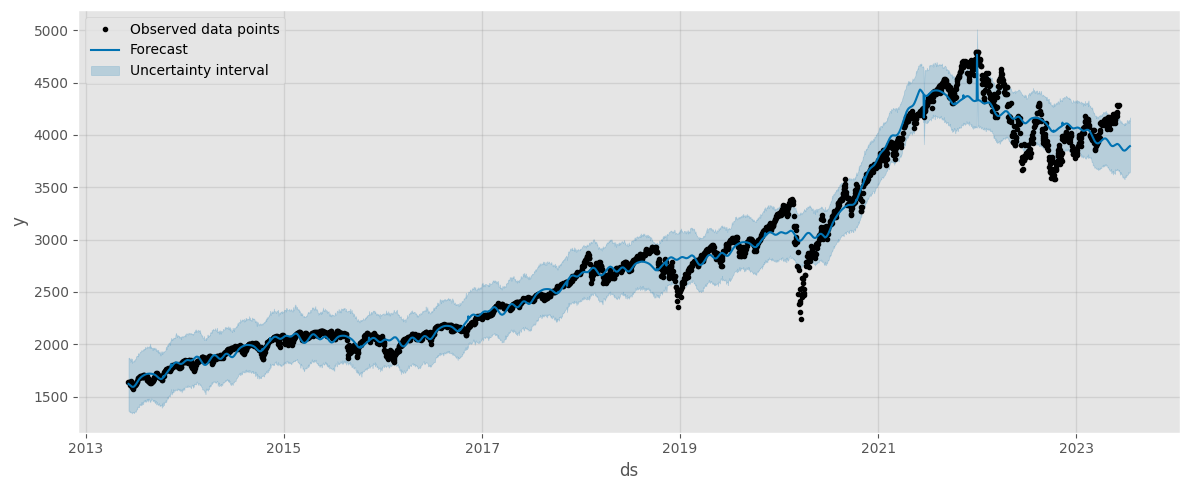

In [40]:
fig, ax = plt.subplots(figsize=(12,5))
model.plot(forecast, ax=ax, include_legend=True)
plt.show()

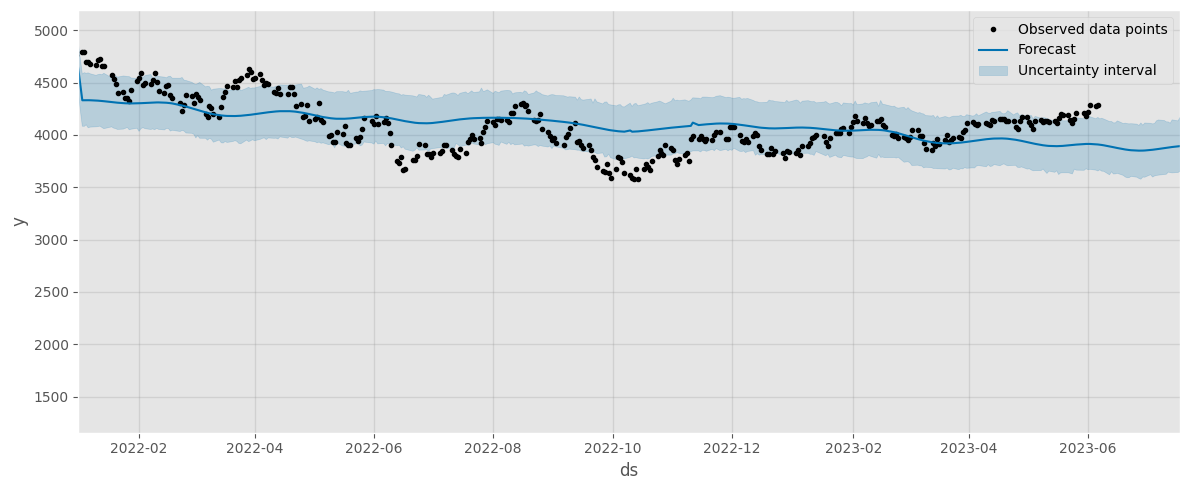

In [28]:
min_value = datetime(2022,1,1)
max_value = forecast['ds'].max()
fig, ax = plt.subplots(figsize=(12,5))
model.plot(forecast, ax=ax, include_legend=True)
ax.set_xlim([min_value, max_value])
plt.show()

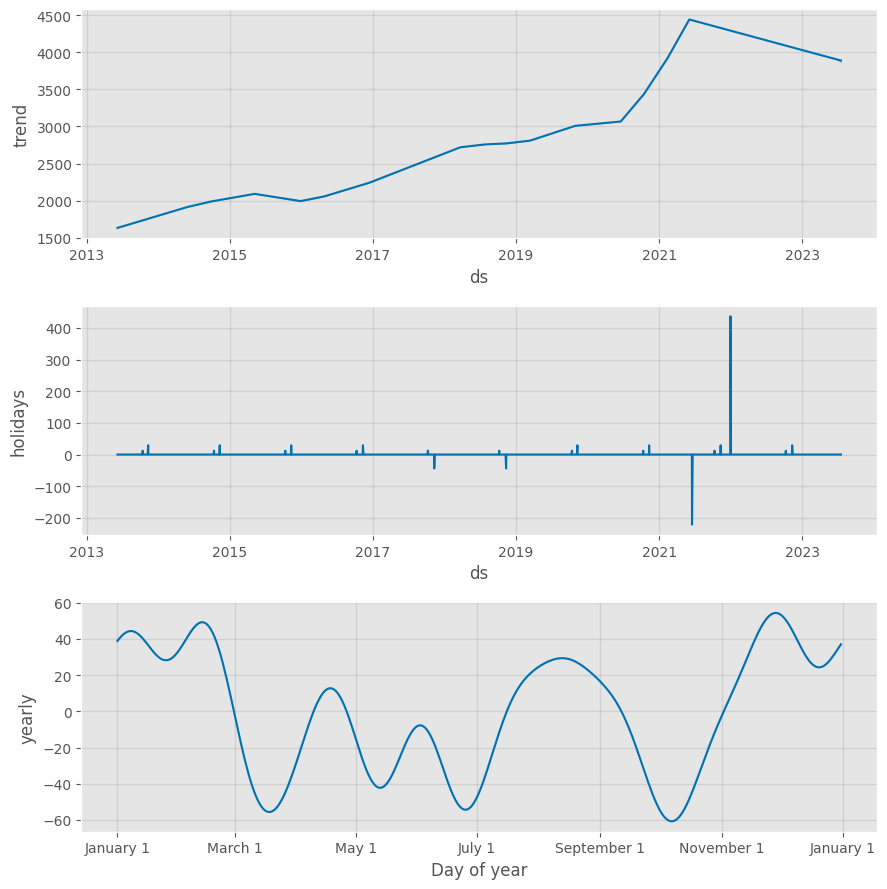

In [29]:
model.plot_components(forecast)
plt.show()

In [30]:
%%time
logging.getLogger("cmdstanpy").disabled = True 
forecast_cv = cross_validation(model, horizon='90 days', parallel='processes')
logging.getLogger("cmdstanpy").disabled = False

CPU times: user 447 ms, sys: 58.6 ms, total: 505 ms
Wall time: 15.8 s


In [31]:
forecast_cv_p = performance_metrics(forecast_cv)
forecast_cv_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,55819.601652,236.261723,145.897614,0.044285,0.026028,0.043085,0.532138
1,10 days,58071.756200,240.980821,148.871337,0.045372,0.028116,0.044134,0.511958
2,11 days,58623.054201,242.121982,151.399588,0.046281,0.030515,0.045058,0.485723
3,12 days,60514.670027,245.997297,154.704051,0.047228,0.032000,0.045988,0.463229
4,13 days,61960.888073,248.919441,157.649480,0.048148,0.033801,0.046924,0.442911


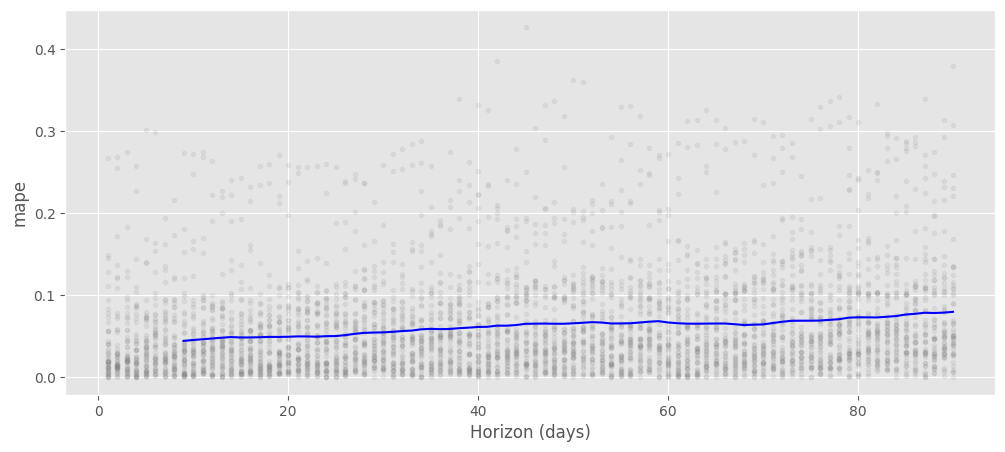

In [32]:
fig, ax = plt.subplots(figsize=(12,5))
plot_cross_validation_metric(forecast_cv, ax=ax, metric='mape')
plt.show()

In [33]:
%%time
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

for params in all_params:
    logging.getLogger("cmdstanpy").disabled = True 
    m = Prophet(**params).fit(df_prophet)  # Fit model with given params
    df_cv = cross_validation(m , horizon='30 days', parallel="processes")
    logging.getLogger("cmdstanpy").disabled = False
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

CPU times: user 20.4 s, sys: 1.7 s, total: 22.1 s
Wall time: 10min 59s


In [34]:
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale        rmse
0                     0.001                     0.01  292.989058
1                     0.001                     0.10  292.698775
2                     0.001                     1.00  292.122592
3                     0.001                    10.00  292.167317
4                     0.010                     0.01  283.931028
5                     0.010                     0.10  283.723781
6                     0.010                     1.00  283.599020
7                     0.010                    10.00  283.824622
8                     0.100                     0.01  257.273471
9                     0.100                     0.10  257.906550
10                    0.100                     1.00  257.966451
11                    0.100                    10.00  257.808781
12                    0.500                     0.01  258.037890
13                    0.500                     0.10  259.795396
14                    0.5

In [35]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


In [38]:
%%time
model_best = Prophet(interval_width=0.95, weekly_seasonality=False, changepoint_prior_scale=0.1, seasonality_prior_scale=0.01)
model_best.add_country_holidays(country_name='US')
model_best.fit(df_prophet)
forecast_best = model_best.predict(future)

12:18:10 - cmdstanpy - INFO - Chain [1] start processing
12:18:10 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 1.24 s, sys: 384 ms, total: 1.62 s
Wall time: 1.67 s


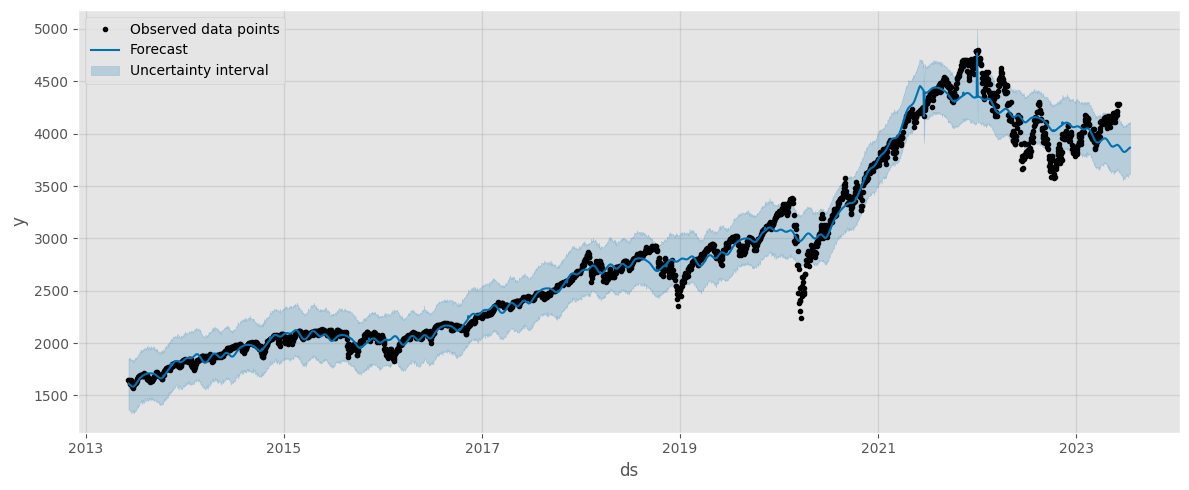

In [41]:
fig, ax = plt.subplots(figsize=(12,5))
model_best.plot(forecast_best, ax=ax, include_legend=True)
plt.show()

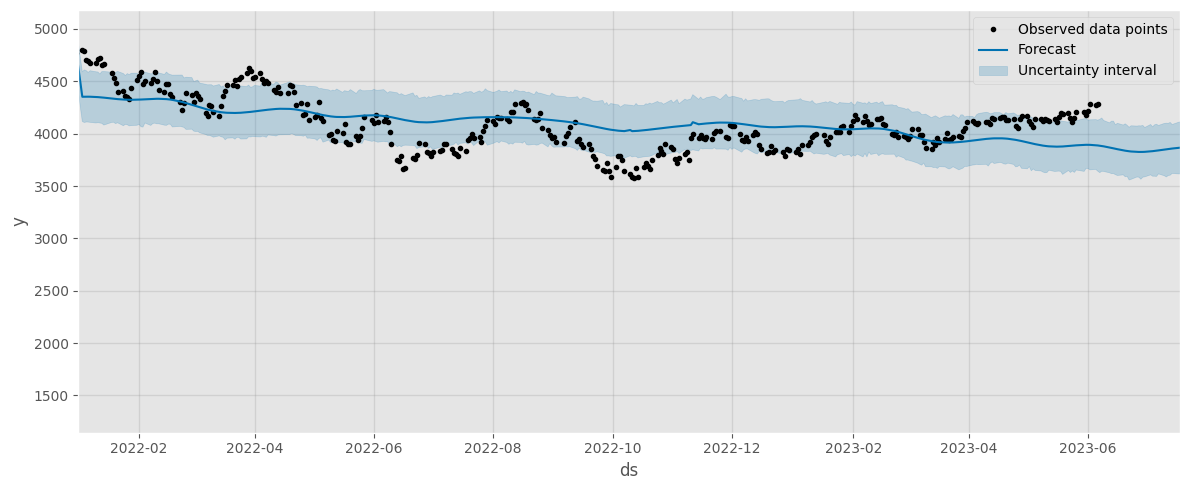

In [42]:
min_value = datetime(2022,1,1)
max_value = forecast_best['ds'].max()
fig, ax = plt.subplots(figsize=(12,5))
model_best.plot(forecast_best, ax=ax, include_legend=True)
ax.set_xlim([min_value, max_value])
plt.show()

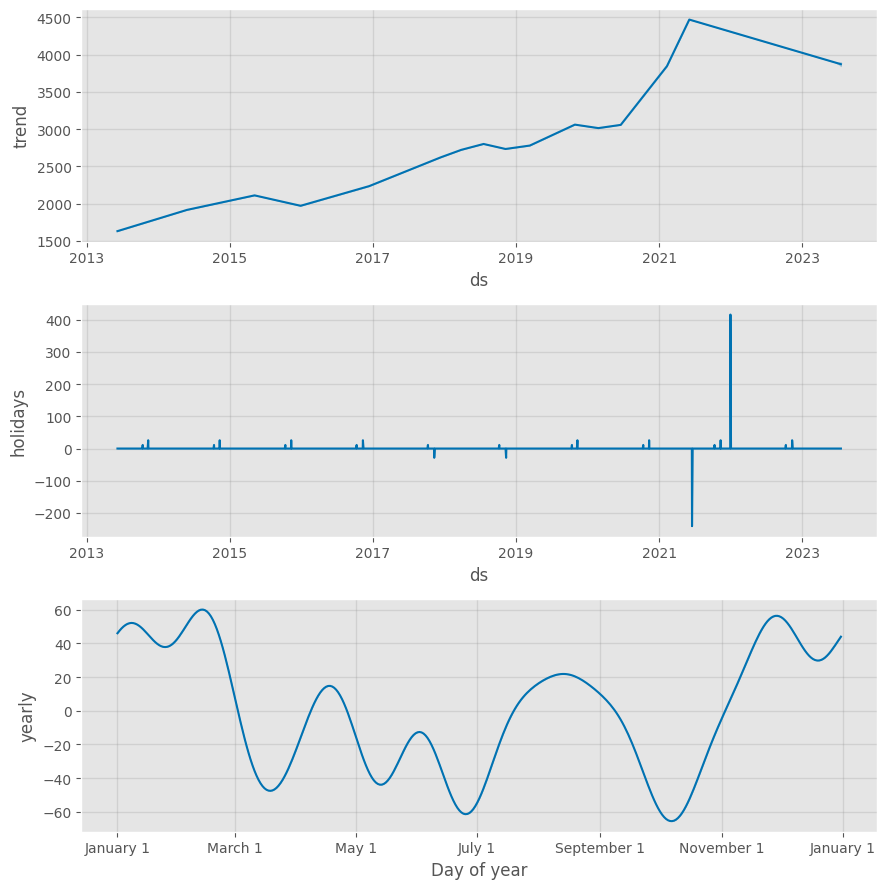

In [43]:
model_best.plot_components(forecast_best)
plt.show()

In [44]:
%%time
logging.getLogger("cmdstanpy").disabled = True 
forecast_cv_best = cross_validation(model_best, horizon='90 days', parallel='processes')
logging.getLogger("cmdstanpy").disabled = False

CPU times: user 341 ms, sys: 88 ms, total: 429 ms
Wall time: 24.8 s


In [45]:
forecast_best_perf = performance_metrics(forecast_cv_best)
forecast_best_perf.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,52958.602328,230.127361,141.253287,0.042727,0.025322,0.041606,0.509716
1,10 days,55024.944191,234.573963,144.791611,0.044032,0.026792,0.042887,0.482810
2,11 days,55485.797452,235.554235,147.329318,0.044940,0.029045,0.043804,0.467557
3,12 days,57292.987875,239.359537,150.176991,0.045643,0.029785,0.044489,0.456278
4,13 days,58609.597918,242.094192,152.651958,0.046336,0.030273,0.045212,0.440497


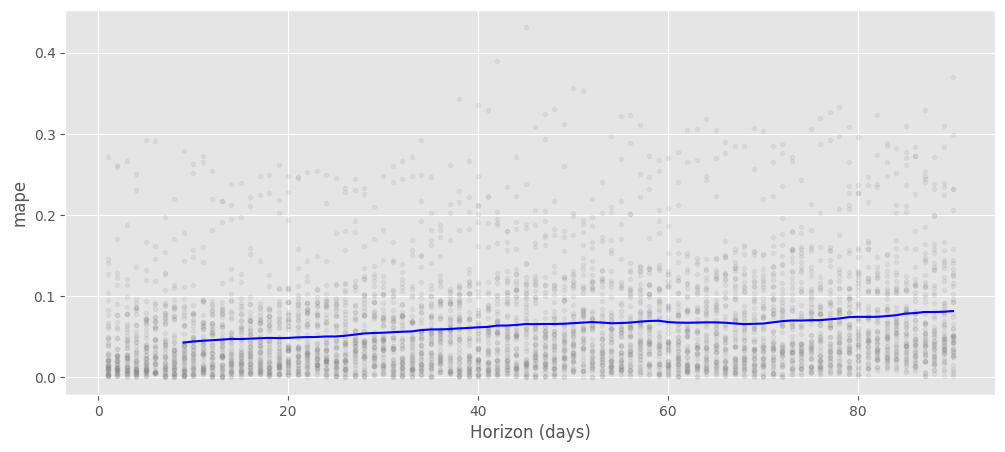

In [46]:
fig, ax = plt.subplots(figsize=(12,5))
plot_cross_validation_metric(forecast_cv_best, ax=ax, metric='mape')
plt.show()

In [47]:
%%time
model_best_season = Prophet(interval_width=0.95, weekly_seasonality=False, changepoint_prior_scale=0.1, seasonality_prior_scale=0.01)
model_best_season.add_seasonality(name='yearly', period=365, fourier_order=8)
model_best_season.add_country_holidays(country_name='US')
model_best_season.fit(df_prophet)
forecast_best_season = model_best_season.predict(future)

13:39:22 - cmdstanpy - INFO - Chain [1] start processing
13:39:23 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 1.15 s, sys: 514 ms, total: 1.66 s
Wall time: 1.66 s


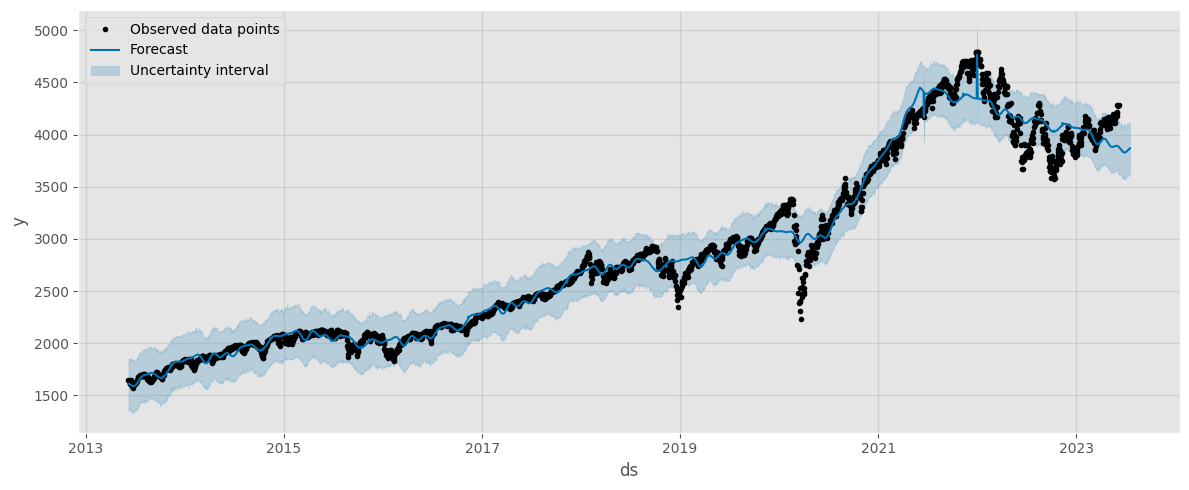

In [48]:
fig, ax = plt.subplots(figsize=(12,5))
model_best_season.plot(forecast_best_season, ax=ax, include_legend=True)
plt.show()

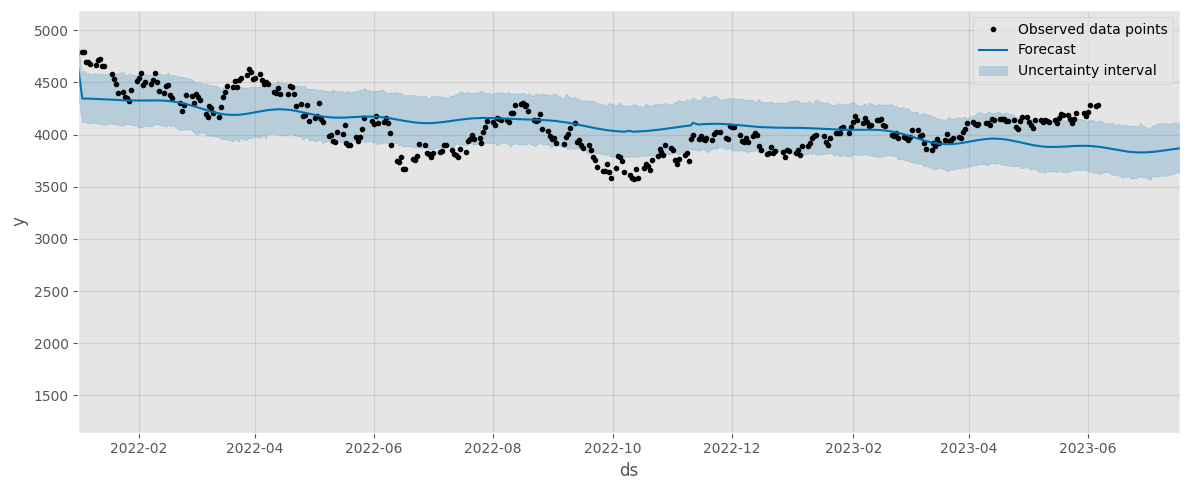

In [49]:
min_value = datetime(2022,1,1)
max_value = forecast_best_season['ds'].max()
fig, ax = plt.subplots(figsize=(12,5))
model_best_season.plot(forecast_best_season, ax=ax, include_legend=True)
ax.set_xlim([min_value, max_value])
plt.show()

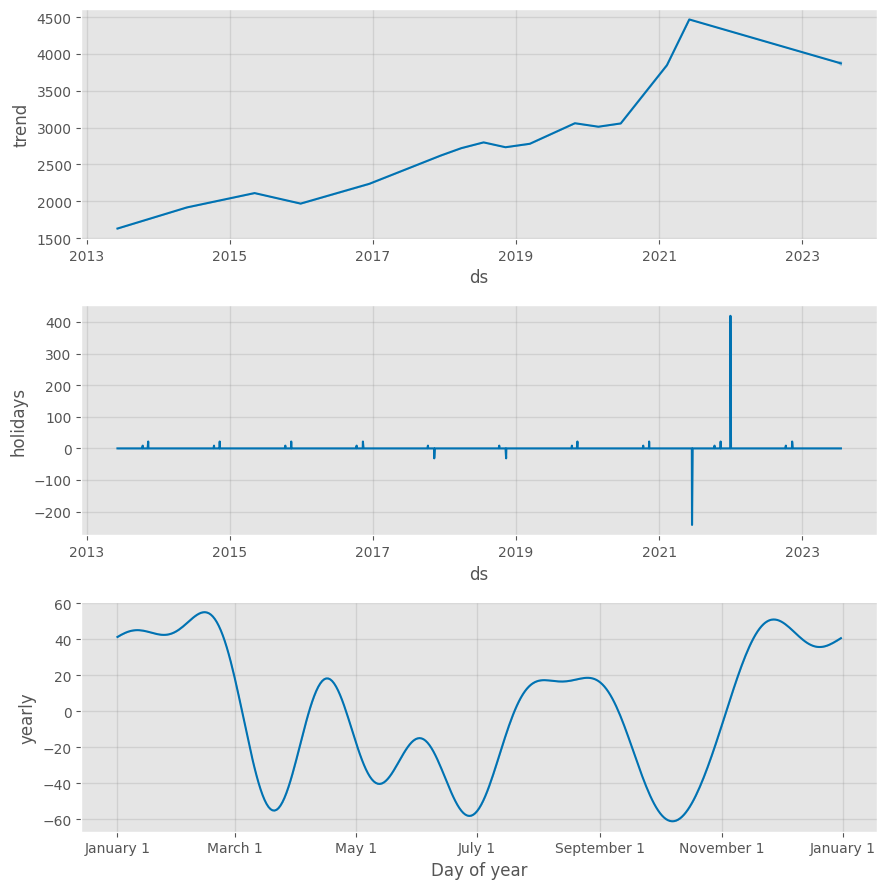

In [50]:
model_best_season.plot_components(forecast_best_season)
plt.show()

In [51]:
%%time
logging.getLogger("cmdstanpy").disabled = True 
forecast_cv_season = cross_validation(model_best_season, horizon='90 days', parallel='processes')
logging.getLogger("cmdstanpy").disabled = False

CPU times: user 449 ms, sys: 74.4 ms, total: 524 ms
Wall time: 21.8 s


In [52]:
forecast_season_perf = performance_metrics(forecast_cv_season)
forecast_season_perf.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,52155.495250,228.375776,140.286692,0.042426,0.025209,0.041325,0.509716
1,10 days,54112.011041,232.619885,143.571823,0.043642,0.027172,0.042518,0.480568
2,11 days,54531.892040,233.520646,145.925626,0.044478,0.028654,0.043363,0.460922
3,12 days,56340.731889,237.362027,148.842301,0.045211,0.029063,0.044077,0.458475
4,13 days,57664.927821,240.135228,151.423296,0.045944,0.030039,0.044841,0.440540


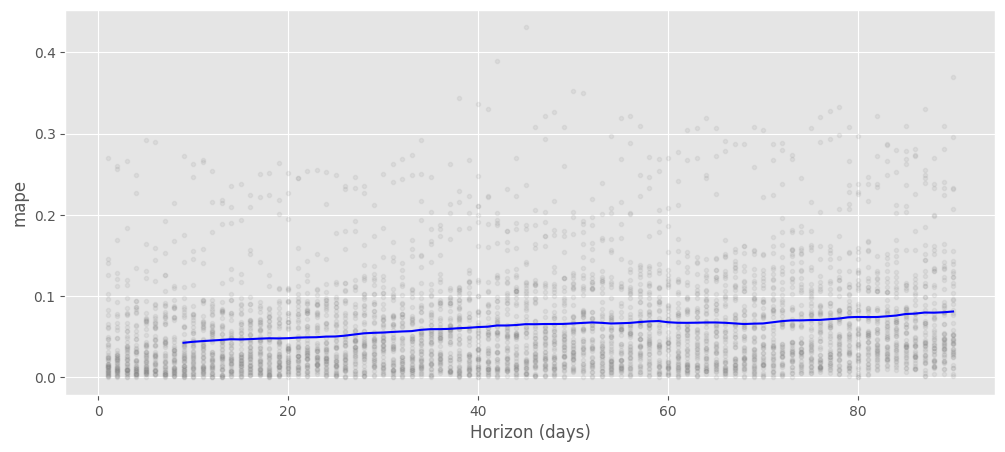

In [53]:
fig, ax = plt.subplots(figsize=(12,5))
plot_cross_validation_metric(forecast_cv_season, ax=ax, metric='mape')
plt.show()